In [1]:
import pandas as pd
from DeepRetail.data.dataloader import Reader
from DeepRetail.transformations.formats import transaction_df
from DeepRetail.forecasting.statistical import StatisticalForecaster

/home/filtheo/DeepRetail/.venv/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
import random

# Set random seed for reproducibility
np.random.seed(42)

# Generate date range for 2023 and 2024
date_range = pd.date_range(start="2023-01-01", end="2024-12-31", freq='D')
date_columns = [date.strftime("%Y-%m-%d") for date in date_range]

# Number of series to simulate
n_series = 20
n_days = len(date_columns)

def random_arima_params():
    p = random.randint(1, 2)
    q = random.randint(0, 2)

    # AR coefficients (must ensure stationarity)
    ar = np.r_[1, -np.random.uniform(0.1, 0.8, size=p)]  # negative sign for AR process
    # MA coefficients
    ma = np.r_[1, np.random.uniform(0.1, 0.8, size=q)]
    return ar, ma

def simulate_series(n_days, ar, ma):
    arma_process = ArmaProcess(ar, ma)
    y = arma_process.generate_sample(nsample=n_days)
    y_positive = np.exp(y - np.min(y) + 0.1)  # make strictly positive
    # Shift and clip before exponentiating
    # y_shifted = y - np.min(y) + 0.1
    # y_clipped = np.clip(y_shifted, 0, 20)  # limit max value before exp
    # y_positive = np.exp(y_clipped)
    return y_positive

# Generate all series
data = []
np.random.seed(42)
for i in range(n_series):
    ar, ma = 1,1 # random_arima_params()
    ts_data = simulate_series(n_days, ar, ma)
    row = [f"ID_{i+1}"] + ts_data.tolist()
    data.append(row)

# Create DataFrame
columns = ['unique_id'] + date_columns
df = pd.DataFrame(data, columns=columns)

# Show first few rows
print(df.head())

# Save to CSV
df.to_csv("daily_data.csv", index=False)


  unique_id  2023-01-01  2023-01-02  2023-01-03  2023-01-04  2023-01-05  \
0      ID_1   46.431657   24.606313   53.998479  129.579837   22.356430   
1      ID_2    7.522380   30.099487    3.646150   56.003322   32.099898   
2      ID_3   18.365775    9.669646   12.666855   40.775873  120.231213   
3      ID_4    4.412012   20.847020    8.895297   26.400740   17.578079   
4      ID_5   24.116312   28.314566   19.587800   27.271690  106.618179   

   2023-01-06  2023-01-07  2023-01-08  2023-01-09  ...  2024-12-22  \
0   22.356797  137.068412   60.867664   17.668669  ...    5.109487   
1   25.849341   53.460676  105.818972   55.181373  ...   25.457453   
2   33.588498    6.845757   35.308186   74.899232  ...   89.332077   
3    9.079489   28.088974  104.778956   14.247779  ...   34.226924   
4   58.943871   52.472570   13.951631    9.042133  ...    7.221694   

   2024-12-23  2024-12-24  2024-12-25  2024-12-26  2024-12-27  2024-12-28  \
0    7.338114   59.414092   33.519682   23.506665  

In [3]:
# Load
df = pd.read_csv('daily_data.csv', index_col=0)

# Get a sample
sampled_df = df.copy()



In [4]:
# convert to transaction
t_df = transaction_df(sampled_df)

In [5]:
# Define the parameters
freq = 'M'
h = 4
holdout = True
cv = 2
models = ['ETS', 'Naive']

In [6]:
# Convert columns to datetime
sampled_df.columns = pd.to_datetime(sampled_df.columns)

# Resample columns to montly frequency
sampled_df = sampled_df.resample('M', axis=1).sum()

In [6]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq)

# Fit the forecaster
forecaster.fit(sampled_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

In [7]:
forecast_df.head()

unique_id       date     cutoff       True  Model          y  cv  fh
0      ID_1 2024-08-31 2024-07-31  28.780592  Naive  23.506664   1   1
1      ID_1 2024-09-30 2024-07-31  39.998783  Naive  23.506664   1   2
2      ID_1 2024-10-31 2024-07-31  16.469458  Naive  23.506664   1   3
3      ID_1 2024-11-30 2024-07-31  12.974198  Naive  23.506664   1   4
8     ID_10 2024-08-31 2024-07-31   1.318322  Naive  43.696407   1   1

In [84]:
residuals = forecaster.calculate_residuals()

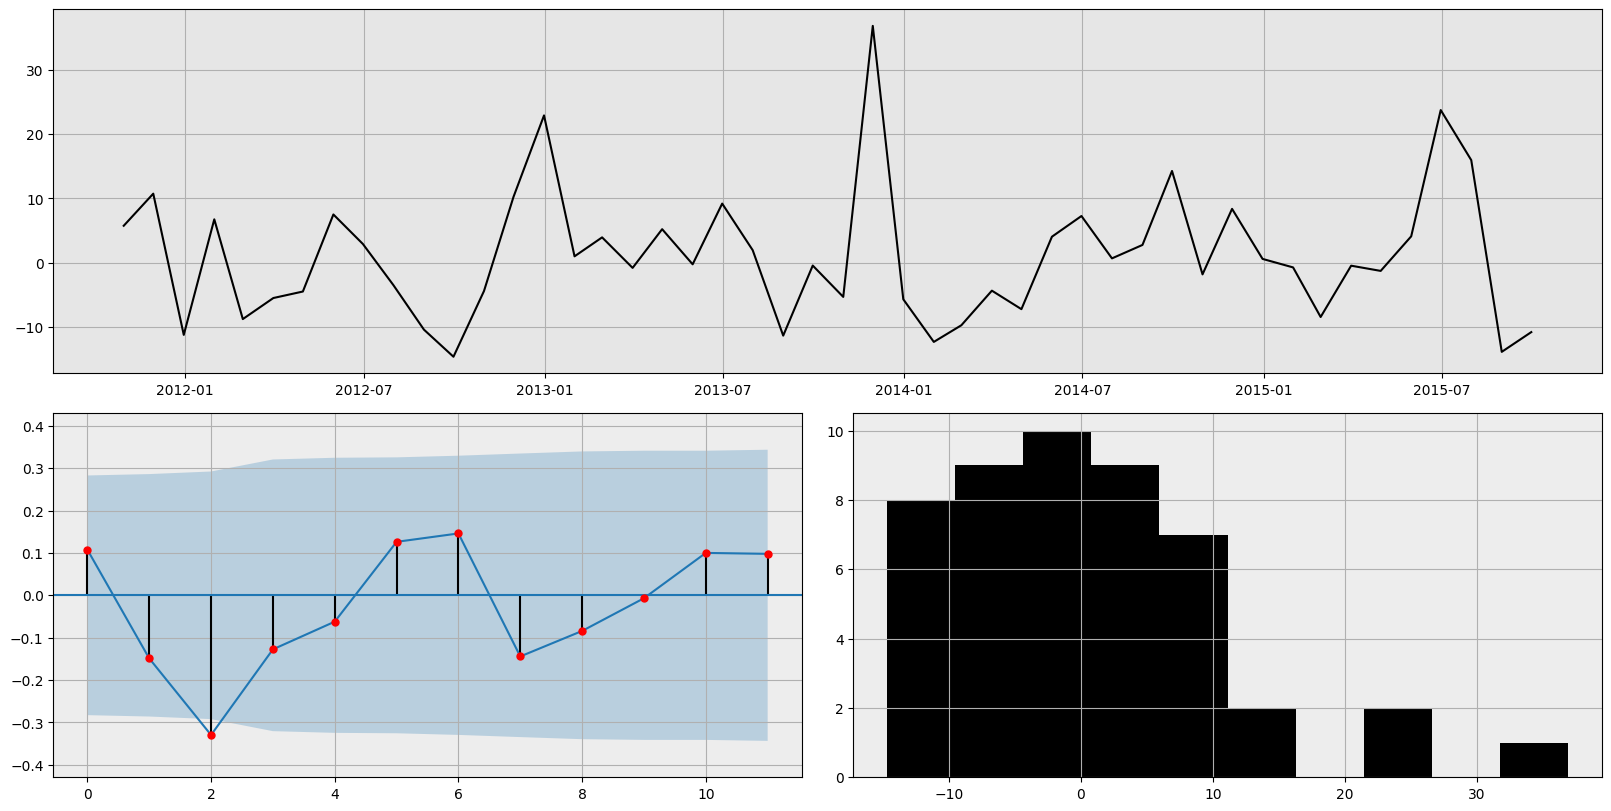

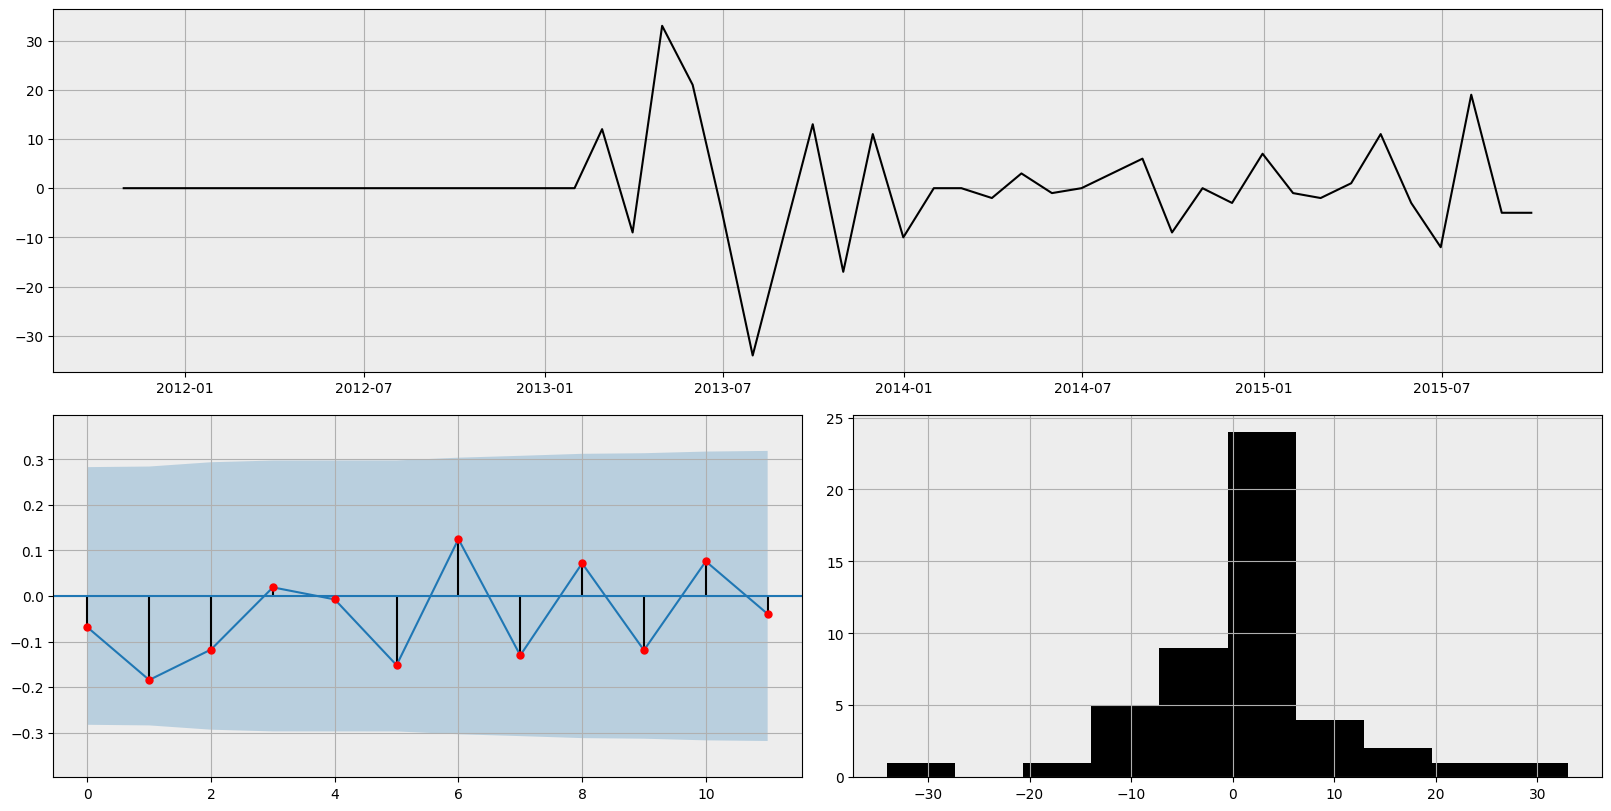

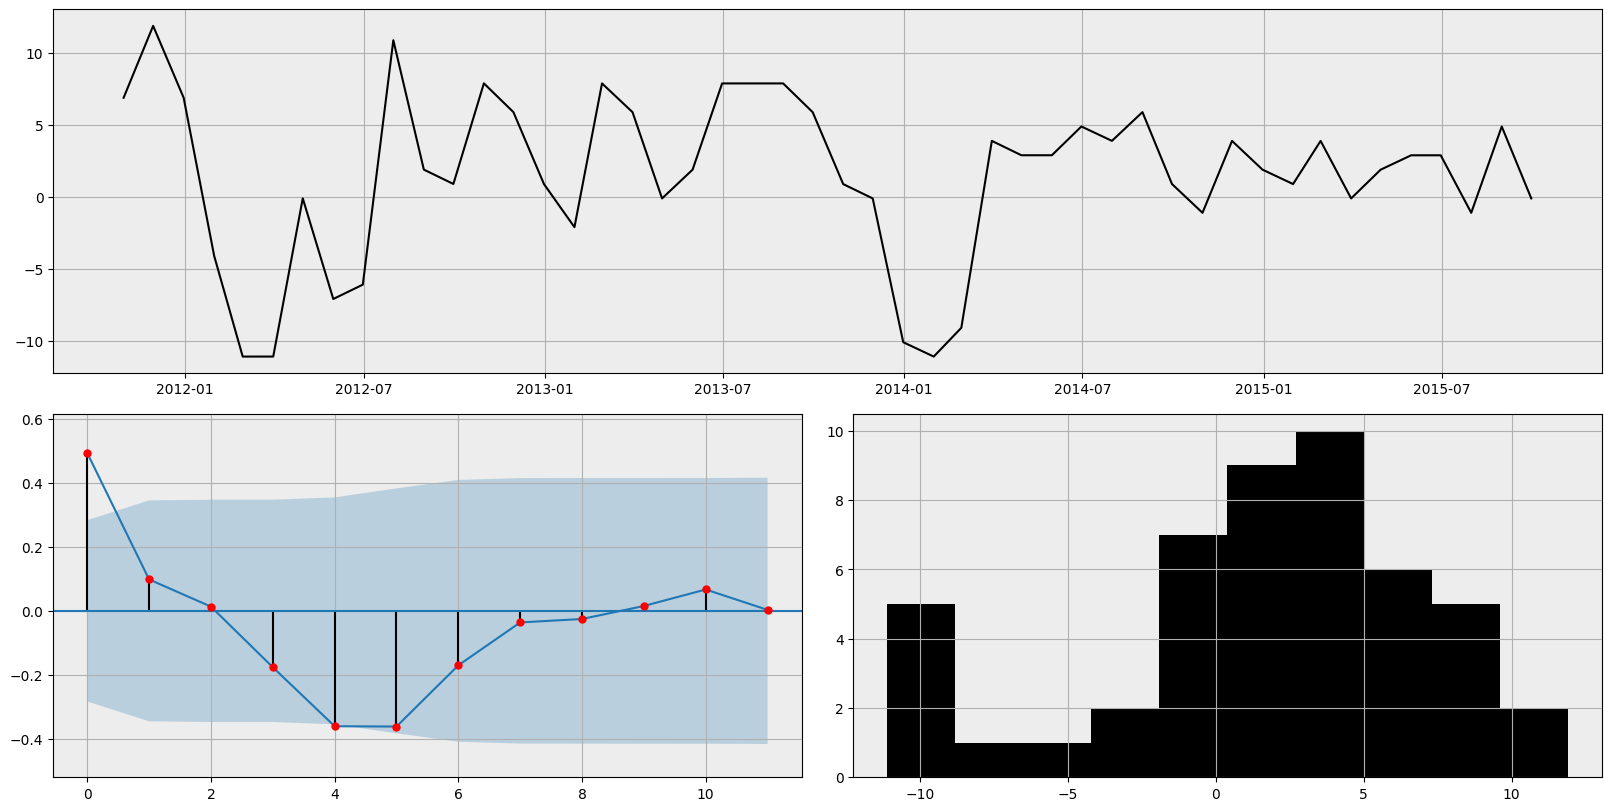

In [95]:
forecaster.residual_diagnosis(model = 'ETS', type = 'random', n = 3)

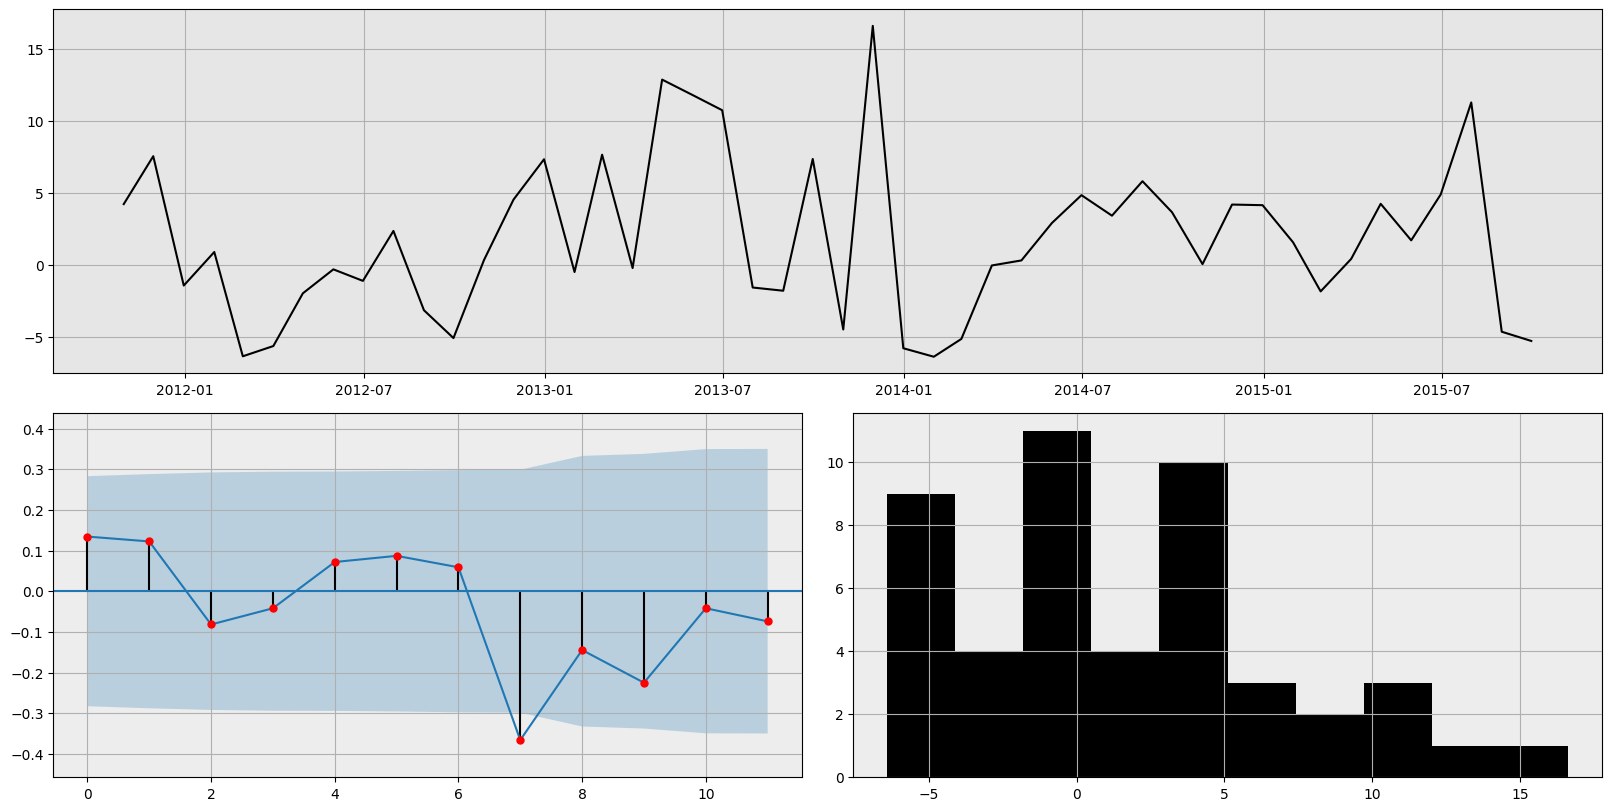

In [96]:
forecaster.residual_diagnosis(model = 'ETS', type = 'aggregate', agg_func = 'mean')

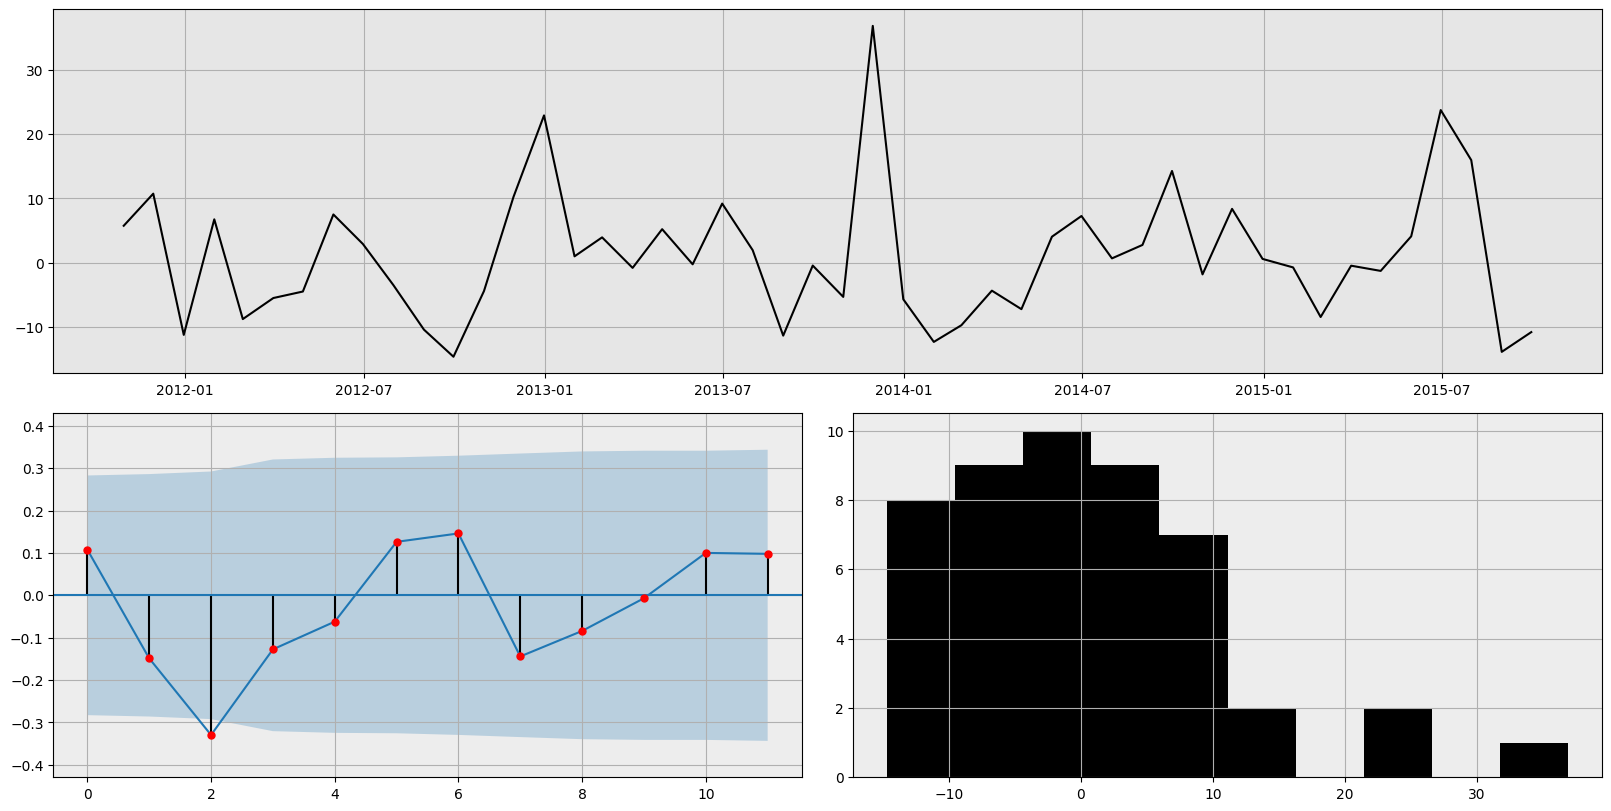

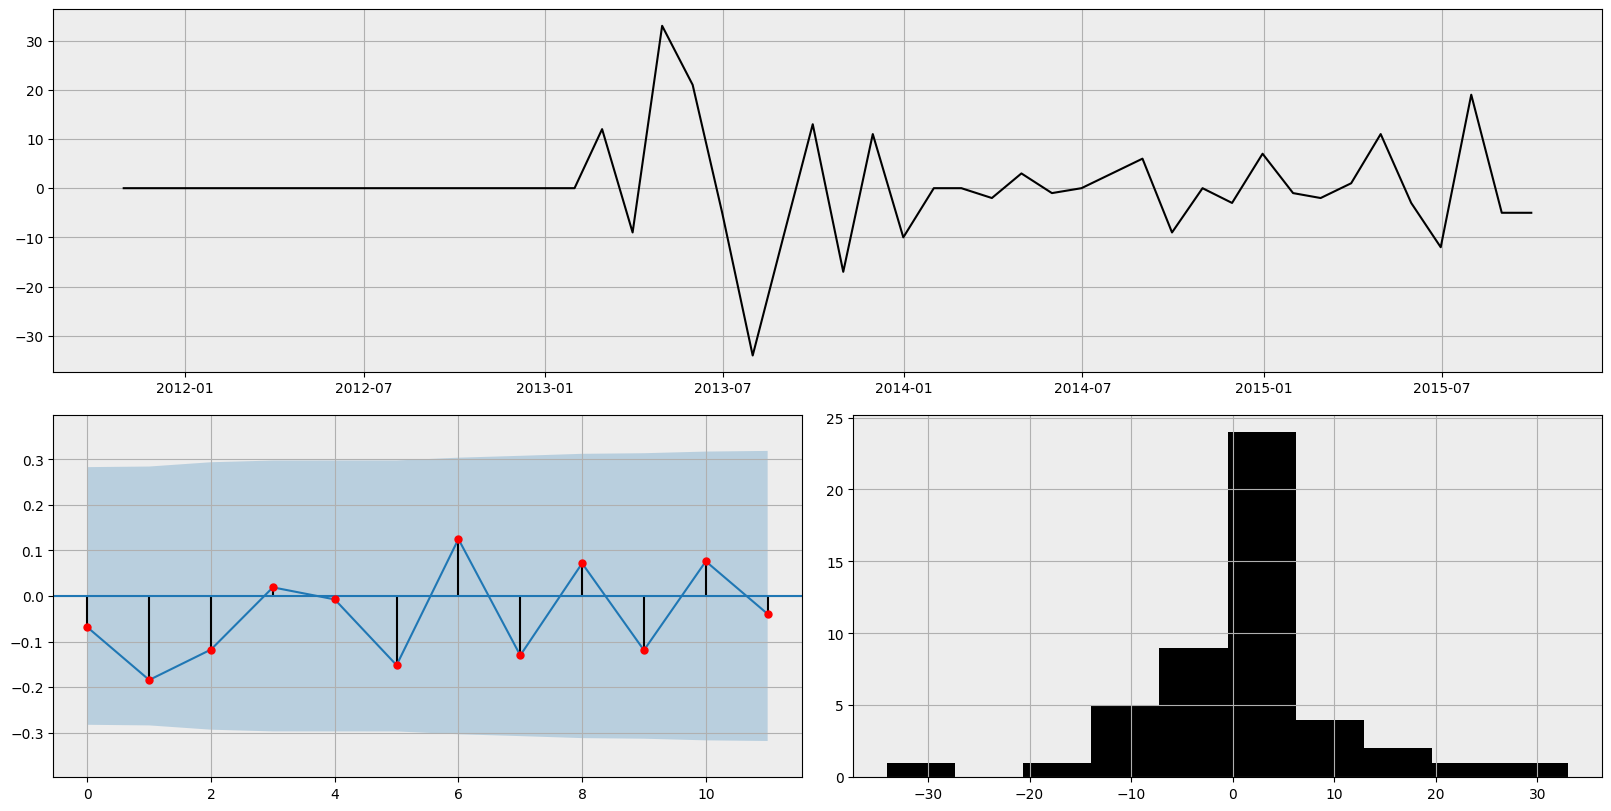

In [97]:
# Get the first two names
names = residuals['unique_id'].unique()[:2]
forecaster.residual_diagnosis(model = 'ETS', type = 'individual', index_ids = names)